In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

from src.data_utils import load_data, load_tokenizer
from nltk.tokenize import wordpunct_tokenize

from src.plots import set_size

from typing import List
from pprint import pprint

SEED = 33
ROOT = "."
LIMIT = None

X_train_cmds, y_train, X_test_cmds, y_test, X_train_malicious_cmd, X_train_baseline_cmd, X_test_malicious_cmd, X_test_baseline_cmd = load_data(ROOT, SEED)

tokenizer = load_tokenizer(
    tokenizer_type="sequential",
    train_cmds=X_train_cmds,
    tokenizer_fn=wordpunct_tokenize,
    max_len=256,
    vocab_size=4096,
)

[!] Loading vocab from './wordpunct_vocab_4096.json'...


In [2]:
# DONT NEED ARRAYS REALLY, TAKES TIME
# train_arr_pkl = os.path.join(ROOT, "data", f"X_train_array_{LONG_MAX_LEN}.pkl")
# if os.path.exists(train_arr_pkl):
#     with open(train_arr_pkl, "rb") as f:
#         X_train_array = pickle.load(f)
# else:
#     X_train_array = tokenizer.transform(X_train_cmds)
#     with open(train_arr_pkl, "wb") as f:
#         pickle.dump(X_train_array, f)

# test_arr_pkl = os.path.join(ROOT, "data", f"X_test_array_{LONG_MAX_LEN}.pkl")
# if os.path.exists(test_arr_pkl):
#     with open(test_arr_pkl, "rb") as f:
#         X_test_array = pickle.load(f)
# else:
#     X_test_array = tokenizer.transform(X_test_cmds)
#     with open(test_arr_pkl, "wb") as f:
#         pickle.dump(X_test_array, f)

In [112]:
X_train_cmds_tokenized = tokenizer.tokenize(X_train_cmds)
X_test_cmds_tokenized = tokenizer.tokenize(X_test_cmds)

## Sequence Length visualisations

### Total lengths

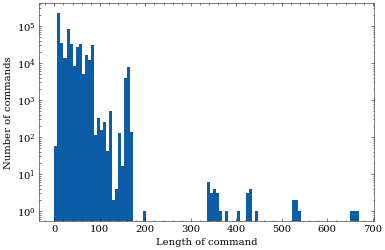

In [4]:
def barplot_lengths(cmds: List[List[str]], ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    lengths = [len(cmd) for cmd in cmds]
    ax.hist(lengths, bins=100)
    ax.set_xlabel("Length of command")
    ax.set_ylabel("Number of commands")
    return ax

fig, ax = plt.subplots()
barplot_lengths(X_train_cmds_tokenized, ax=ax)
ax.set_yscale('log')

### Cutting 

In [120]:
# filter out commands that are longer than 256
def print_len_stat(cmds_tokenized, seqlen=256):
    cmds_tokenized_long = [cmd for cmd in cmds_tokenized if len(cmd) >= seqlen]
    cmds_tokenized_short = [cmd for cmd in cmds_tokenized if len(cmd) <= seqlen]
    # ratio in %
    ratio = len(cmds_tokenized_long) / len(cmds_tokenized) * 100
    print(f"Number of commands longer than {seqlen} tokens: ({ratio:.4f}%) | Longer: {len(cmds_tokenized_long)} | Shorter: {len(cmds_tokenized_short)} | Total: {len(cmds_tokenized)}")
    return cmds_tokenized_long, cmds_tokenized_short

In [121]:
X_train_cmds_tokenized_long, X_train_cmds_tokenized_short = print_len_stat(X_train_cmds_tokenized, seqlen=256)
X_train_cmds_tokenized_long, X_train_cmds_tokenized_short = print_len_stat(X_train_cmds_tokenized, seqlen=128)

Number of commands longer than 256 tokens: (0.0066%) | Longer: 35 | Shorter: 532979 | Total: 533014
Number of commands longer than 128 tokens: (2.2345%) | Longer: 11910 | Shorter: 521104 | Total: 533014


In [122]:
X_test_cmds_tokenized_long, X_test_cmds_tokenized_short = print_len_stat(X_test_cmds_tokenized, seqlen=256)
X_test_cmds_tokenized_long, X_test_cmds_tokenized_short = print_len_stat(X_test_cmds_tokenized, seqlen=128)

Number of commands longer than 256 tokens: (0.0149%) | Longer: 70 | Shorter: 470059 | Total: 470129
Number of commands longer than 128 tokens: (0.1134%) | Longer: 533 | Shorter: 469596 | Total: 470129


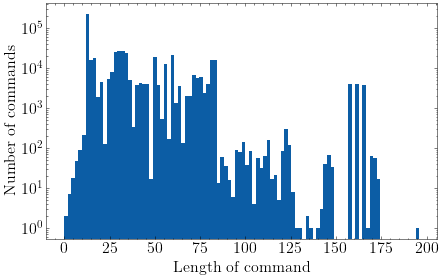

In [103]:
fig, ax = plt.subplots(figsize=set_size())
barplot_lengths(X_train_cmds_tokenized_short, ax=ax)
ax.set_yscale('log')

# increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

# savefig in /img as pdf
fig.savefig("img/train_cmd_lengths.pdf", bbox_inches='tight', dpi=300)

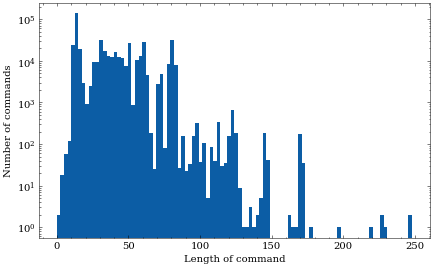

In [10]:
fig, ax = plt.subplots(figsize=set_size())
barplot_lengths(X_test_cmds_tokenized_short, ax=ax)
ax.set_yscale('log')
# savefig in /img as pdf
fig.savefig("img/test_cmd_lengths.pdf", bbox_inches='tight', dpi=300)

### Vocab Size visualisations

In [11]:
# select elements from X_train_cmds_tokenized where y_train == 1
y_rvrs_mask = y_train == 1
X_train_cmds_tokenized_rvrs = [cmd for cmd, mask in zip(X_train_cmds_tokenized, y_rvrs_mask) if mask]

# same for 0
y_base_mask = y_train == 0
X_train_cmds_tokenized_base = [cmd for cmd, mask in zip(X_train_cmds_tokenized, y_base_mask) if mask]

In [12]:
print(len(X_train_cmds_tokenized_rvrs))
print(len(X_train_cmds_tokenized_base))

266501
266513


In [78]:
def venn_diagram(cmds_tokens_rvrs: List[List[str]], cmds_tokens_base: List[List[str]], ax = None, vocab=None, labels=["Reverse Shell\nTokens", "Baseline\nTokens"]):
    from matplotlib_venn import venn2
    if ax is None:
        fig, ax = plt.subplots()
    cmds_tokens_rvrs_flat = [item for sublist in cmds_tokens_rvrs for item in sublist]
    cmds_tokens_base_flat = [item for sublist in cmds_tokens_base for item in sublist]
    if vocab is not None:
        cmds_tokens_rvrs_flat = [item for item in cmds_tokens_rvrs_flat if item in vocab]
        cmds_tokens_base_flat = [item for item in cmds_tokens_base_flat if item in vocab]
    vd = venn2(
        [set(cmds_tokens_rvrs_flat), set(cmds_tokens_base_flat)], 
        # normalize_to=25,
        set_labels=labels, 
        ax=ax
    )
    
    return ax, vd

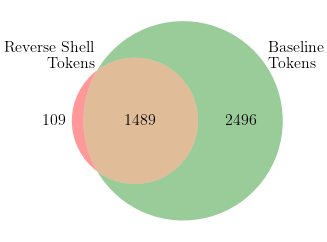

In [93]:
plt.style.use(['science'])

fig, ax = plt.subplots(figsize=set_size())
ax, vd = venn_diagram(X_train_cmds_tokenized_rvrs, X_train_cmds_tokenized_base, ax=ax, vocab=tokenizer.vocab, labels = ["Reverse Shell\nTokens", "Baseline\nTokens"])

vd.get_label_by_id('A').set_x(-0.42)
vd.get_label_by_id('A').set_y(.45)
vd.get_label_by_id('B').set_x(0.55)
vd.get_label_by_id('B').set_y(0.45)
vd.get_label_by_id('10').set_x(-0.64)

# increase font size of labels
for text in vd.set_labels:
    text.set_fontsize(16)
for text in vd.subset_labels:
    text.set_fontsize(16)

# # save as pdf in /img
fig.savefig("img/venn_train_cmds_tokens_vocab.pdf", bbox_inches='tight', dpi=300)

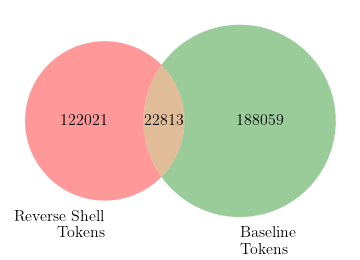

In [86]:
fig, ax = plt.subplots(figsize=set_size())
ax, vd = venn_diagram(X_train_cmds_tokenized_rvrs, X_train_cmds_tokenized_base, ax=ax, labels = ["Reverse Shell\nTokens", "Baseline\nTokens"])

# increase font size of labels
for text in vd.set_labels:
    text.set_fontsize(16)
for text in vd.subset_labels:
    text.set_fontsize(16)

# save as pdf in /img
fig.savefig("img/venn_train_cmds_tokens_no_vocab.pdf", bbox_inches='tight', dpi=300)

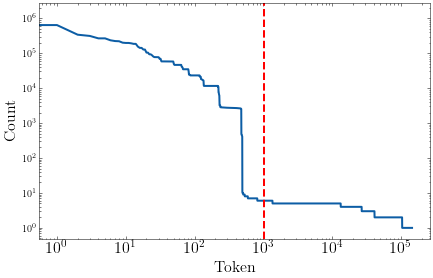

In [102]:
def plot_token_counter(cmds_tokens: List[List[str]], vocab_size = 4096, ax = None):
    from collections import Counter
    if ax is None:
        fig, ax = plt.subplots()
    cmds_tokens_flat = [item for sublist in cmds_tokens for item in sublist]
    counter = Counter(cmds_tokens_flat)
    counter = counter.most_common()
    # as line plot
    ax.plot([item[1] for item in counter], linewidth=2)
    # plot red dashed line at vocab size
    ax.axvline(x=vocab_size, color='r', linestyle='--', linewidth=2)
    return ax

fig, ax = plt.subplots(figsize=set_size())
ax = plot_token_counter(X_train_cmds_tokenized_rvrs, ax=ax, vocab_size=1024)
ax.set_yscale('log')
ax.set_xscale('log')

# increase size of xticks, xticklabels, xlabel, ylabel
ax.tick_params(axis='x', which='major', labelsize=16)
ax.set_xlabel("Token", fontsize=16)
_ = ax.set_ylabel("Count", fontsize=16)


In [124]:
# quantifying how many tokens in % from all tokens are in the vocab
def print_vocab_coverage(cmds_tokens: List[List[str]], vocab):
    cmds_tokens_flat = [item for sublist in cmds_tokens for item in sublist]
    cmds_tokens_flat = [item for item in cmds_tokens_flat if item in vocab]
    ratio = len(cmds_tokens_flat) / len([item for sublist in cmds_tokens for item in sublist]) * 100
    # positive metrics
    print(f"Vocab coverage: {ratio:.4f}% | Tokens in vocab: {len(cmds_tokens_flat)} | Total tokens: {len([item for sublist in cmds_tokens for item in sublist])}")
    # negative metrics
    print(f"Vocab coverage: {100 - ratio:.4f}% | Tokens not in vocab: {len([item for sublist in cmds_tokens for item in sublist]) - len(cmds_tokens_flat)} | Total tokens: {len([item for sublist in cmds_tokens for item in sublist])}")

print_vocab_coverage(X_train_cmds_tokenized_rvrs, tokenizer.vocab)

Vocab coverage: 97.3494% | Tokens in vocab: 11980647 | Total tokens: 12306854
Vocab coverage: 2.6506% | Tokens not in vocab: 326207 | Total tokens: 12306854


In [130]:
file = r"logs_adversarial_evasion\nl2bash_prepend\X_test_malicious_with_attack_128_cmd_sample_5000.json"
import json
with open(os.path.join(ROOT, file), "r") as f:
    data = json.load(f)

data_tokenized = tokenizer.tokenize(data)

In [132]:
data_tokenized_long, data_tokenized_short = print_len_stat(data_tokenized, seqlen=256)

Number of commands longer than 256 tokens: (0.0000%) | Longer: 0 | Shorter: 5000 | Total: 5000
